In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [4]:
img_dir = "C:/Users/skoni/Desktop/kaggle-mask-project/Medical mask/Medical mask/Medical Mask/images"
train_list = pd.read_csv("C:/Users/skoni/Desktop/kaggle-mask-project/train.csv")
submission_list = pd.read_csv("C:/Users/skoni/Desktop/kaggle-mask-project/submission.csv")


In [5]:
classes = ['face_with_mask','face_no_mask']
train_set = train_list[train_list['classname'].isin(classes)].sort_values('name') # filtrowanie listy danych aby pozystac tylko interesyjace nas dane
print(train_set)

           name   x1   x2   y1   y2       classname
13381  1801.jpg  451  186  895  697    face_no_mask
3463   1802.jpg  110   71  273  272  face_with_mask
14835  1803.jpg  126   75  303  333  face_with_mask
5867   1804.jpg  112  113  262  307  face_with_mask
6194   1805.jpg  728  180  853  336  face_with_mask
...         ...  ...  ...  ...  ...             ...
13549  6433.png  669  105  798  281  face_with_mask
13550  6433.png  765  142  976  364  face_with_mask
13548  6433.png  536  152  665  333  face_with_mask
13547  6433.png  146  107  304  313  face_with_mask
9508   6434.jpg  315   82  775  783  face_with_mask

[5749 rows x 6 columns]


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_set['target'] = le.fit_transform(train_set.classname) # encoding klas na wartosci numeryczne
train_set.head()

,name,x1,x2,y1,y2,classname,target
13381,1801.jpg,451,186,895,697,face_no_mask,0
3463,1802.jpg,110,71,273,272,face_with_mask,1
14835,1803.jpg,126,75,303,333,face_with_mask,1
5867,1804.jpg,112,113,262,307,face_with_mask,1
6194,1805.jpg,728,180,853,336,face_with_mask,1


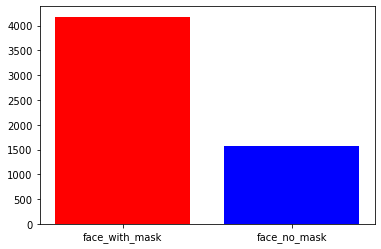

In [7]:
plt.bar(['face_with_mask','face_no_mask'], train_set.target.value_counts(), color = ['red','blue']); # reprezentacja graficzna ilosci ludzi z ubranymi maskami do tych bez masek 


In [8]:
train_images = train_set.name.unique().tolist() # nazwy zdjec ktorych uzyjemy do trenowania modelu
test_images = submission_list.name.unique().tolist() # nazwy zdjec ktorych uzyjemy do testowania modelu


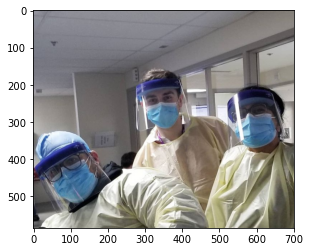

In [9]:
i = np.random.choice(len(train_images))# wybieramy losowy index
img = plt.imread(os.path.join(img_dir,train_images[i])) # wczytujemy obraz o losowo wybranym indexie ze zbioru do trenowania
plt.imshow(img) # wyswietlamy obraz


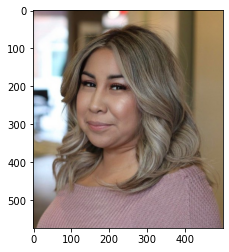

In [10]:
i = np.random.choice(len(test_images))# wybieramy losowy index
img = plt.imread(os.path.join(img_dir,test_images[i])) # wczytujemy obraz o losowo wybranym indexie ze zbioru testowego
plt.imshow(img) # wyswietlamy obraz

In [11]:
boxes = []
for i in range(len(train_set)): # iterujemy przez wszystkie zdjecia do trenowania
    box_list = [] # lista na zaznaczone pola z twarzami z maska lub bez 
    for box in train_set.iloc[i][["x1",'x2','y1','y2']]: # z kazdego obrazka wyciagamy wszystkie pola
        box_list.append(box) #dodajemy pole do listy
    boxes.append(box_list) # dodajemy liste poszczegolnego pola do listy zdjecie-> lista pól
    
train_set["boxes"] = boxes # tworzymy nowa kolumne w trainset na pola
print(train_set)


           name   x1   x2   y1   y2       classname  target  \
13381  1801.jpg  451  186  895  697    face_no_mask       0   
3463   1802.jpg  110   71  273  272  face_with_mask       1   
14835  1803.jpg  126   75  303  333  face_with_mask       1   
5867   1804.jpg  112  113  262  307  face_with_mask       1   
6194   1805.jpg  728  180  853  336  face_with_mask       1   
...         ...  ...  ...  ...  ...             ...     ...   
13549  6433.png  669  105  798  281  face_with_mask       1   
13550  6433.png  765  142  976  364  face_with_mask       1   
13548  6433.png  536  152  665  333  face_with_mask       1   
13547  6433.png  146  107  304  313  face_with_mask       1   
9508   6434.jpg  315   82  775  783  face_with_mask       1   

                      boxes  
13381  [451, 186, 895, 697]  
3463    [110, 71, 273, 272]  
14835   [126, 75, 303, 333]  
5867   [112, 113, 262, 307]  
6194   [728, 180, 853, 336]  
...                     ...  
13549  [669, 105, 798, 281]  
135

In [12]:
def get_boxes(filename): # zwraca pola dla okreslonego pliku
    boxes = []
    for box in train_set[train_set["name"] == filename]["boxes"]:# iteracja po mozliwych listach pol w obrazku
        boxes.append(box)
    return boxes


In [13]:
def draw_box(image, boxes): # rysuje pola na wyznaczonym obrazku
    plt.imshow(image)
    cx = plt.gca() # kontekst do rysowania na obrazie
    for box in boxes:
      x1, x2, y1, y2 = box[0], box[1], box[2], box[3]
      rect_box = plt.Rectangle((x1, x2), y1-x1, y2-x2, fill=False, color='b', linewidth=1) # tworzenie pola na twarzy
      cx.add_patch(rect_box)
    plt.show()
    


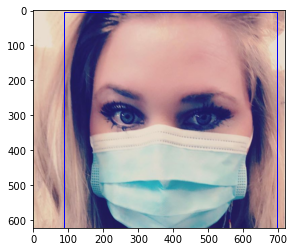

In [14]:
i = np.random.choice(len(train_images))
image = plt.imread(os.path.join(img_dir,train_images[i]))
boxes = get_boxes(train_images[i])
draw_box(image, boxes)
#rysowanie pola na twarzy na randomowym obrazku

In [15]:
img_size=128 # wielkosc do ktorej przekonwertujemy obraz
data=[]
for i in range(len(train_set)):
    x1, x2, y1, y2 = train_set.iloc[i]['boxes']# pobieramy wspolrzedne pola
    image_name = train_set.iloc[i]['name'] # nazwa obrazku
    img_array = cv2.imread(os.path.join(img_dir,image_name)) # wczytujemy zdjecie
    img_face = img_array[x2:y2,x1:y1] # wycinamy zawartosc zdjecia aby zostala tylko twarz
    img = cv2.resize(img_face,(img_size,img_size)) # przeksztalcamy wycieta twarz na wymagana przez nas wielkosc
    data.append([img,train_set.iloc[i]['target']]) # dodajemy do listy list


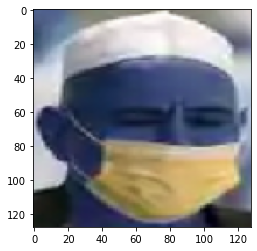

In [16]:
i = np.random.choice(range(len(data)))
plt.imshow(data[i][0]); # sprawdzania dzialania 


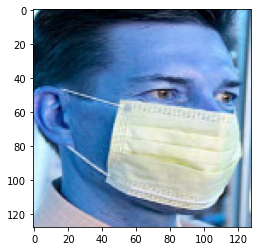

In [17]:
X=[]# tworzenie zbioru X i Y do trenowania sieci neuronowej
Y=[]
for features, labels in data: # zbior X zawiera twarze, natomiast zbior Y odpowiedz na to czy na twarzy jest maska czy nie 
    X.append(features)
    Y.append(labels)
X = np.array(X)/255 # zbiory przeksztalcamy do formatu akceptowalnego przez siec
Y = np.array(Y)

In [18]:
model = Sequential() # tworzymy model

model.add(Conv2D(filters=32, kernel_size=5, activation="relu", padding='same', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0

In [19]:
from sklearn.model_selection import train_test_split
# dzielimy dane na zbior do treningu i do trenowania 
X_train,X_val,y_train,y_val = train_test_split(X, Y,train_size=0.8,random_state=0)


In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),loss='binary_crossentropy', metrics=['accuracy']) 
# fitujemy model
history = model.fit(X_train,y_train,batch_size=32,epochs=40,validation_data=(X_val, y_val),)


Epoch 1/40
144/144 [==============================] - 40s 277ms/step - loss: 0.4637 - accuracy: 0.7663 - val_loss: 0.3039 - val_accuracy: 0.8817
Epoch 2/40
144/144 [==============================] - 37s 260ms/step - loss: 0.2841 - accuracy: 0.8800 - val_loss: 0.3419 - val_accuracy: 0.8670
Epoch 3/40
144/144 [==============================] - 38s 264ms/step - loss: 0.2670 - accuracy: 0.8871 - val_loss: 0.2439 - val_accuracy: 0.9122
Epoch 4/40
144/144 [==============================] - 38s 263ms/step - loss: 0.2542 - accuracy: 0.8932 - val_loss: 0.2741 - val_accuracy: 0.8730
Epoch 5/40
144/144 [==============================] - 38s 264ms/step - loss: 0.2446 - accuracy: 0.8952 - val_loss: 0.2793 - val_accuracy: 0.8930
Epoch 6/40
144/144 [==============================] - 38s 263ms/step - loss: 0.2307 - accuracy: 0.9058 - val_loss: 0.2119 - val_accuracy: 0.9217
Epoch 7/40
144/144 [==============================] - 38s 261ms/step - loss: 0.2072 - accuracy: 0.9163 - val_loss: 0.2082 - val_ac

In [25]:
model.save('Desktop/assets') # zapisujemy model

INFO:tensorflow:Assets written to: Desktop/assets\assets
